# Parquet Dataframe

In [2]:
import re

# === Sentiment Mapping (你要的格式) ===
news_sentiment_mapping = {
    # 正面情感 (温度上升可能更高)
    "[1][a] Warm Surge": "positive",
    "[1][b] Prolonged Warmth": "positive",
    "[1][c] Heat Impact": "positive",
    
    # 中性情感 (无明确温度趋势)
    "[2][a] Weather Event Only": "neutral",
    "[2][b] Mixed Pattern": "neutral",
    "[2][c] Uncertain/Speculative": "neutral",
    "[2][d] Seasonal Transition": "neutral",
    
    # 负面情感 (温度下降可能更高)
    "[3][a] Cold Surge": "negative",
    "[3][b] Cold Hazards": "negative",
    "[3][c] Extreme Cold Impact": "negative",
    "[3][d] Winter Storm": "negative"
}
# === 关键词触发表 ===
keyword_triggers = {
    # === 正面情感 (温度上升) ===
    "[1][a] Warm Surge": [
        r"hot", r"hot and humid", r"heat wave", r"heat advisory",
        r"record high", r"abnormally warm", r"unusually warm",
        r"summerlike", r"springlike", r"heat dome", r"ridge building",
        r"temperatures in the 90s", r"temperatures in the upper 80s",
        r"dew points in the upper 70s", r"high dew points",
        r"extreme heat", r"excessive heat warning"
    ],
    
    "[1][b] Prolonged Warmth": [
        r"warming trend", r"warmer than average", r"daytime highs rising",
        r"mild overnight lows", r"above normal", r"southerly flow",
        r"subtropical moisture", r"return flow from gulf", r"persistent warmth",
        r"prolonged warm pattern", r"unseasonably warm", r"gradual warming",
        r"mild conditions", r"temperatures climbing"
    ],
    
    "[1][c] Heat Impact": [
        r"dangerous heat", r"excessive heat", r"heat index",
        r"health risk", r"prolonged heat stress", r"high heat and humidity",
        r"heat related illness", r"heat stress", r"extreme heat advisory"
    ],
    
    # === 中性情感 ===
    "[2][a] Weather Event Only": [
        r"thunderstorm", r"hail", r"flash flood", r"heavy rain",
        r"lightning", r"gusty winds", r"damaging winds", r"dust storm",
        r"wildfire", r"tornado", r"atmospheric river", r"non-convective winds",
        r"severe weather", r"property damage", r"crop damage", r"water rescue"
    ],
    
    "[2][b] Mixed Pattern": [
        r"warm and moist airmass.*cold front", r"warm-up.*before front",
        r"then cooling", r"temperature gradient", r"frontal boundary",
        r"flip-flop forecast", r"cold front.*followed by warming",
        r"stalled front", r"warm front lifted north through", r"cold front moved through",
        r"instability ahead of", r"enhanced lift ahead of", r"pre-frontal convection"
    ],
    
    "[2][c] Uncertain/Speculative": [
        r"\bpossible\b", r"\bmay\b", r"\bmight\b", r"\bcould\b",
        r"chance of", r"uncertain", r"model disagreement",
        r"forecast varies", r"watching", r"monitoring", r"expected",
        r"likely", r"potential", r"possibly"
    ],
    
    "[2][d] Seasonal Transition": [
        r"typical seasonal", r"normal transition", r"average temperatures",
        r"seasonal pattern", r"typical for this time of year", r"gradual cooling",
        r"typical spring", r"typical fall", r"normal seasonal change"
    ],
    
    # === 负面情感 (温度下降) ===
    "[3][a] Cold Surge": [
        r"cold front", r"cold air", r"cold surge", r"polar air",
        r"arctic", r"cold unstable airmass", r"temperatures dropping",
        r"below normal", r"north wind", r"northeast wind", r"advancing cold front",
        r"cold air mass", r"cold advection", r"cooling trend", r"dropping temperatures"
    ],
    
    "[3][b] Cold Hazards": [
        r"freeze", r"frost", r"wind chill", r"snow",
        r"snow level lowering", r"low elevation snow", r"winter precipitation",
        r"flurries", r"hard freeze", r"ice storm", r"freezing rain",
        r"below freezing", r"sub-zero", r"coldest temperatures", r"chilly"
    ],
    
    "[3][c] Extreme Cold Impact": [
        r"dangerously cold", r"life-threatening cold", r"extreme cold",
        r"deep freeze", r"record low", r"bitter cold", r"severe cold",
        r"extreme wind chill", r"coldest on record", r"frigid"
    ],
    
    "[3][d] Winter Storm": [
        r"winter storm", r"heavy snow", r"blizzard", r"snowstorm",
        r"significant snowfall", r"accumulating snow", r"winter precipitation",
        r"heavy snow bands", r"snow accumulation", r"winter weather advisory"
    ]
}

def classify_news_text(text: str) -> str:
    """
    输入: 一段新闻文本
    输出: sentiment ('positive'/'neutral'/'negative')
    """
    text_lower = text.lower()
    matched_labels = []

    # 遍历 mapping
    for label, patterns in keyword_triggers.items():
        for pat in patterns:
            if re.search(pat, text_lower):
                matched_labels.append(label)

    # === 分类规则 ===
    if not matched_labels:
        return "neutral"  # 默认中性

    # 如果同时有冷和暖 → Neutral Mixed Pattern
    has_warm = any(lbl.startswith("[1]") for lbl in matched_labels)
    has_cold = any(lbl.startswith("[3]") for lbl in matched_labels)
    if has_warm and has_cold:
        return news_sentiment_mapping["[2][b] Mixed Pattern"]

    # 否则取第一个匹配的 sentiment
    for lbl in matched_labels:
        return news_sentiment_mapping[lbl]

# === 示例 ===
sample1 = "Record high temperatures and a heat wave spread across the region."
sample2 = "A cold front moved into an unusually warm, moist airmass."
sample3 = "Thunderstorms brought hail and flooding with no mention of temperature."

print(classify_news_text(sample1))  # positive
print(classify_news_text(sample2))  # neutral
print(classify_news_text(sample3))  # neutral


positive
neutral
neutral


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter
import pandas as pd
from sklearn.linear_model import LinearRegression

def compute_temperature_trend(past_temperatures, future_temperatures=None):
    past_temperatures = np.array(past_temperatures)
    n_past = len(past_temperatures)
    if n_past % 24 != 0:
        raise ValueError("Past must be multiple of 24 hours.")
    
    # Past trend: always use slope
    past_days = past_temperatures.reshape(-1, 24)
    past_daily = np.mean(past_days, axis=1).reshape(-1, 1)
    x_past = np.arange(len(past_daily)).reshape(-1, 1)
    slope_past = LinearRegression().fit(x_past, past_daily).coef_[0][0]
    
    past_trend = ("increasing" if slope_past >= 0.25 else 
                  "decreasing" if slope_past <= -0.25 else "stable")
    
    if future_temperatures is None:
        return past_trend
    
    future_temperatures = np.array(future_temperatures)
    n_future = len(future_temperatures)
    if n_future % 24 != 0:
        raise ValueError("Future must be multiple of 24 hours.")
    
    n_future_days = n_future // 24
    
    if n_future_days == 1:
        # Compare future day vs last past day
        diff = np.mean(future_temperatures) - np.mean(past_days[-1])
        future_trend = ("increasing" if diff >= 1.5 else 
                        "decreasing" if diff <= -1.5 else "stable")
    else:
        # Use slope over future days
        future_days = future_temperatures.reshape(n_future_days, 24)
        future_daily = np.mean(future_days, axis=1).reshape(-1, 1)
        x_future = np.arange(n_future_days).reshape(-1, 1)
        slope_future = LinearRegression().fit(x_future, future_daily).coef_[0][0]
        future_trend = ("increasing" if slope_future >= 0.25 else 
                        "decreasing" if slope_future <= -0.25 else "stable")
    
    return past_trend, future_trend



def plot_temperature_trend(row, figsize=(14, 6)):
    """
    绘制 input_window 和 output_window 温度曲线，并标注趋势。
    
    Parameters:
        row: DataFrame 的一行（如 df.iloc[0]），需包含：
             - 'input_timestamps', 'output_timestamps'
             - 'input_window', 'output_window'
             - 'past_trend', 'future_trend'
    """
    # 解析时间戳
    input_ts = pd.to_datetime(row['input_timestamps'])
    output_ts = pd.to_datetime(row['output_timestamps'])
    
    # 温度数据
    input_temp = np.array(row['input_window'])
    output_temp = np.array(row['output_window'])
    
    # 创建图形
    fig, ax = plt.subplots(figsize=figsize)
    
    # 绘制过去温度（input_window）
    ax.plot(input_ts, input_temp, label='Past 7 Days (Input)', color='steelblue', linewidth=2)
    
    # 绘制未来温度（output_window）
    ax.plot(output_ts, output_temp, label='Next Day (Output)', color='crimson', linewidth=2.5, linestyle='--')
    
    # 标注趋势文字
    trend_text = f"Past Trend: {row['past_trend'].upper()} | Future Trend: {row['future_trend'].upper()}"
    ax.set_title(f"Temperature Forecast — {trend_text}", fontsize=14, fontweight='bold', pad=20)
    
    # 格式化 x 轴日期
    ax.xaxis.set_major_formatter(DateFormatter("%m-%d %H:%M"))
    plt.xticks(rotation=45, ha='right')
    
    # 美化
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left')
    ax.set_xlabel("Time")
    ax.set_ylabel("Temperature (°C)")
    ax.set_xlim(input_ts[0], output_ts[-1])  # 连续时间轴
    
    # 可选：绘制每日均值点（用于 past_trend 的回归基础）
    if len(input_temp) % 24 == 0:
        n_days = len(input_temp) // 24
        daily_means = []
        daily_mid_times = []
        for i in range(n_days):
            day_temp = input_temp[i*24:(i+1)*24]
            day_ts = input_ts[i*24:(i+1)*24]
            daily_means.append(np.mean(day_temp))
            # 取当天中午12点作为代表时间点
            mid_time = day_ts[12]  # 12:00
            daily_mid_times.append(mid_time)
        
        ax.scatter(daily_mid_times, daily_means, 
                   color='darkblue', s=80, zorder=5, 
                   label='Daily Mean (Past)', edgecolor='white')
    
    plt.tight_layout()
    plt.show()




## Short

In [13]:
import json
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm 
from pathlib import Path
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from collections import defaultdict, Counter
from pathlib import Path


data_dir = Path("./processed/weather/aligned_in7days_out1days")
json_files = list(data_dir.glob("*.json"))

if not json_files:
    raise ValueError(f"No JSON files under {data_dir} directory")

all_data = []

for file in tqdm(json_files, desc="Loading & Parsing JSON Files"):
    try:
        with open(file, "r", encoding="utf-8") as f:
            json_data = json.load(f)
            row = {
                "file_name": file.name,  # str
                "input_window_len": len(json_data.get("input_window", [])),  # int
                "output_window_len": len(json_data.get("output_window", [])),  # int
                "input_timestamps": json_data.get("input_timestamps"),  # list
                "output_timestamps": json_data.get("output_timestamps"),  # list
                "input_window": json_data.get("input_window"),  # list
                "output_window": json_data.get("output_window"),  # list
                "text": json_data.get("text"),  # dict
                "hasrain": json_data.get("hasrain") #str
            }
            all_data.append(row)
            
    except Exception as e:
        print(f"Failed to load {file.name}: {str(e)}")
        continue


df = pd.DataFrame(all_data)
df = df[(df['input_window_len']==168) & (df['output_window_len']==24)]
df['input_window_mean'] = df['input_window'].apply(lambda x: np.mean(x) if len(x) > 0 else np.nan)
df['output_window_mean'] = df['output_window'].apply(lambda x: np.mean(x) if len(x) > 0 else np.nan)
df['input_window_std'] = df['input_window'].apply(lambda x: np.std(x, ddof=0))
df['output_window_std'] = df['output_window'].apply(lambda x: np.std(x, ddof=0))

df = df[df['input_window_std']>=0.1]
df = df[df['output_window_std']>=0.1]

df

Loading & Parsing JSON Files: 100%|██████████| 1959/1959 [00:00<00:00, 7852.46it/s]


,file_name,input_window_len,output_window_len,input_timestamps,output_timestamps,input_window,output_window,text,hasrain,input_window_mean,output_window_mean,input_window_std,output_window_std
0,USW00013874_34.json,168,24,"[2011-03-20 00:00:00, 2011-03-20 01:00:00, 201...","[2011-03-27 00:00:00, 2011-03-27 01:00:00, 201...","[25.6, 24.383333333333333, 23.166666666666668,...","[13.3, 13.200000000000001, 13.1, 13.0, 13.0, 1...","The following events were reported: Hail, Ligh...",True,16.621726,11.854167,4.749539,1.304828
1,USW00014739_10.json,168,24,"[2020-10-01 00:00:00, 2020-10-01 01:00:00, 202...","[2020-10-08 00:00:00, 2020-10-08 01:00:00, 202...","[17.8, 17.233333333333334, 16.666666666666668,...","[12.8, 13.166666666666668, 13.533333333333333,...",The following events were reported: Thundersto...,False,15.151786,13.804167,3.091969,1.477088
2,USW00014820_27.json,168,24,"[2011-07-13 00:00:00, 2011-07-13 01:00:00, 201...","[2011-07-20 00:00:00, 2011-07-20 01:00:00, 201...","[29.4, 28.133333333333333, 26.866666666666667,...","[28.3, 27.2, 26.1, 25.0, 23.9, 22.8, 21.7, 21....",The following events were reported: Flash Floo...,False,24.796726,27.008333,3.258741,4.556246
3,USW00094846_24.json,168,24,"[2006-09-27 00:00:00, 2006-09-27 01:00:00, 200...","[2006-10-04 00:00:00, 2006-10-04 01:00:00, 200...","[17.8, 17.616666666666667, 17.433333333333334,...","[24.4, 24.4, 24.4, 24.4, 24.4, 24.4, 24.4, 23....",The following events were reported: Flash Floo...,False,15.034524,19.070833,4.899121,4.473443
4,USW00094789_20.json,168,24,"[2017-01-18 00:00:00, 2017-01-18 01:00:00, 201...","[2017-01-25 00:00:00, 2017-01-25 01:00:00, 201...","[4.4, 4.8, 5.2, 5.6, 5.3999999999999995, 5.2, ...","[4.4, 4.033333333333333, 3.6666666666666665, 3...",The following events were reported: Heavy Rain...,False,6.161310,5.908333,1.918048,2.806066
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1953,USW00013904_4.json,168,24,"[2023-09-18 00:53:00, 2023-09-18 01:53:00, 202...","[2023-09-25 00:53:00, 2023-09-25 01:53:00, 202...","[30.6, 28.9, 26.7, 26.7, 22.8, 21.7, 21.1, 20....","[35.0, 32.8, 31.1, 26.0, 27.2, 26.7, 27.8, 27....","The following events were reported: Hail, Thun...",False,29.544048,30.275000,5.205420,3.624138
1954,USW00094847_36.json,168,24,"[2006-06-15 00:00:00, 2006-06-15 01:00:00, 200...","[2006-06-22 00:00:00, 2006-06-22 01:00:00, 200...","[23.3, 22.2, 21.1, 20.0, 18.7, 17.400000000000...","[21.1, 20.933333333333334, 20.76666666666667, ...","The following events were reported: Hail, Thun...",False,22.706250,23.158333,3.941898,2.919495
1955,USW00094789_7.json,168,24,"[2012-09-02 00:00:00, 2012-09-02 01:00:00, 201...","[2012-09-09 00:00:00, 2012-09-09 01:00:00, 201...","[23.9, 23.7, 23.5, 23.3, 23.133333333333333, 2...","[22.8, 21.5, 20.2, 18.9, 18.9, 18.9, 18.9, 18....",The following events were reported: Thundersto...,False,24.060417,21.020833,1.660057,2.151245
1957,USW00023293_38.json,168,24,"[2005-12-25 00:53:00, 2005-12-25 01:53:00, 200...","[2006-01-01 00:53:00, 2006-01-01 01:53:00, 200...","[18.3, 17.2, 16.7, 16.1, 15.6, 14.4, 13.3, 13....","[13.3, 12.8, 11.7, 10.6, 10.0, 10.0, 10.0, 10....",The following events were reported: Flood. The...,True,13.911310,11.783333,2.167823,1.504069


In [ ]:
#print("=== input_window ===")
#print(df['input_window_mean'].describe())
#print(df['input_window_std'].describe())

#print("\n=== output_window ===")
#print(df['output_window_mean'].describe())
#print(df['output_window_std'].describe())

#df[df['input_window_std']==0]

count    1820.000000
mean        2.545396
std         1.252612
min         0.169358
25%         1.583485
50%         2.408474
75%         3.340234
max         7.341746
Name: output_window_std, dtype: float64


In [14]:
df['past_trend'] = df['input_window'].apply(
    lambda x: compute_temperature_trend(x, None)
)

df['future_trend'] = df.apply(
    lambda row: compute_temperature_trend(row['input_window'], row['output_window'])[-1],
    axis=1
)

#df['news_future_trend'] = df.apply(
#    lambda row: classify_news_text(row['text']),
#    axis=1
#)


print(df['past_trend'].value_counts())
print(df['future_trend'].value_counts())
#print(df['news_future_trend'].value_counts())

past_trend
increasing    762
stable        536
decreasing    522
Name: count, dtype: int64
future_trend
decreasing    783
stable        752
increasing    285
Name: count, dtype: int64


The following events were reported: Flood, Hail. These occurred near station USW00023293, approximately 20.1104 km away, between 2010-01-20 06:45:00 and 2010-01-20 16:00:00. The events included records with hailstones measuring 1.0 inches. The flood was caused by Heavy Rain. The events resulted in 0 injuries and 1 fatalities. No significant property or crop damage was reported. Episode Narrative: The third in a series of significant storms brought strong winds and heavy rain to the San Francisco and Monterey Bay areas. This storm, the strongest of the week, developed over the Pacific Ocean with a strong parent low pressure based in the Gulf of Alaska. Around 159,000 customers lost power across the San Francisco Bay area with nearly 22,000 customers without power in the Monterey Bay area. Numerous power lines and trees were knocked down when strong wind combined with saturated soil. Also, areas of flooding occurred causing mainly problems for vehicles. The third in a series of significa

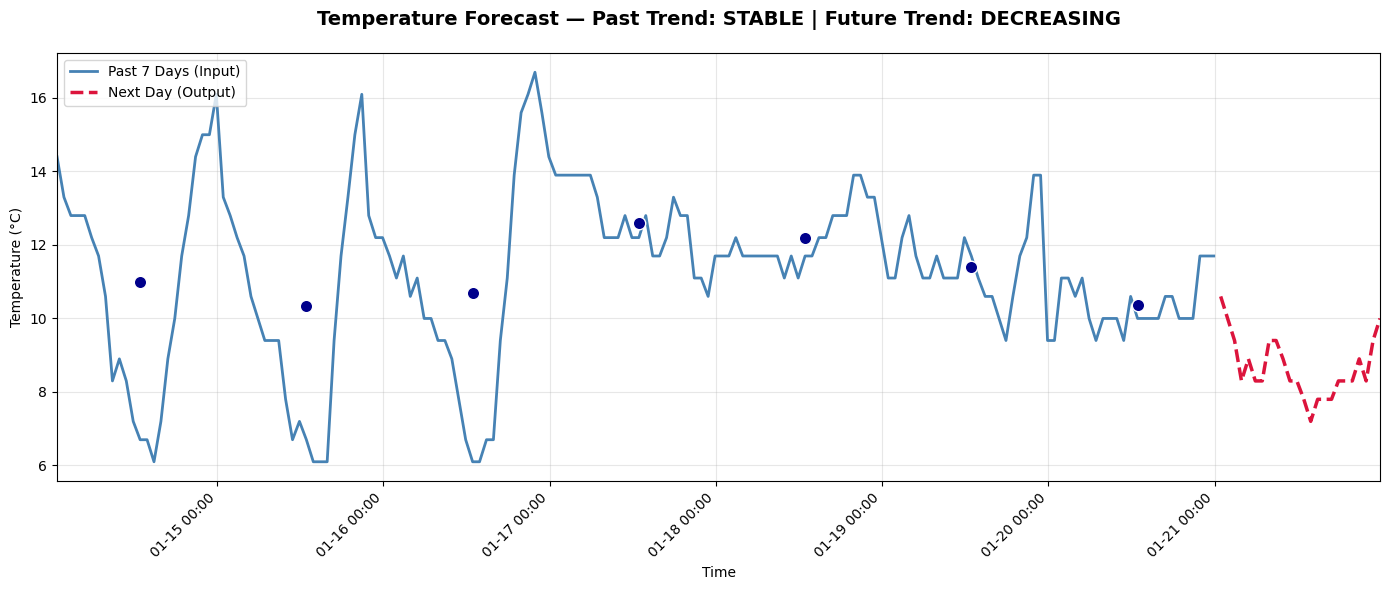

In [21]:
idx = 100
print(df.iloc[idx]['text'])
plot_temperature_trend(df.iloc[idx])

In [ ]:
print(f"\n Data loaded successfully! Total rows: {len(df)}")
#df.to_parquet('./processed/weather/aligned_in7days_out1days/weather_short.parquet')


 Data loaded successfully! Total rows: 1820


In [4]:
from dataset import WeatherDataset
from transformers import AutoTokenizer, AutoModelForCausalLM

data_dir = "./processed/weather/aligned_in7days_out1days"
tokenizer = AutoTokenizer.from_pretrained("../llm/Qwen1.5-MoE-A2.7B")  
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id  
dataset = WeatherDataset(data_dir=data_dir,
                        tokenizer=tokenizer,
                        input_seq_len=168,
                        output_seq_len=24,
                        max_text_length=2048)

Loaded: weather_short.parquet, 1949 original samples in total


Processing: 100%|██████████| 1949/1949 [00:05<00:00, 332.31it/s]


Finished dataset preparation
Number of valid samples: 1949, input_len: 168, output_len: 24


In [6]:
import numpy as np
import torch

sample = dataset[0]

for key, value in sample.items():
    if isinstance(value, np.ndarray):
        print(f"{key}: type={type(value)}, dtype={value.dtype}, shape={value.shape}")
    elif isinstance(value, torch.Tensor):
        print(f"{key}: type={type(value)}, dtype={value.dtype}, shape={value.shape}")
    else:
        print(f"{key}: type={type(value)}, value={value}")

#sample

file_name: type=<class 'str'>, value=USW00013874_34.json
input_timestamps: type=<class 'numpy.ndarray'>, dtype=float32, shape=(168,)
output_timestamps: type=<class 'numpy.ndarray'>, dtype=float32, shape=(24,)
input_window: type=<class 'torch.Tensor'>, dtype=torch.float32, shape=torch.Size([168])
output_window: type=<class 'torch.Tensor'>, dtype=torch.float32, shape=torch.Size([24])
text_input_ids: type=<class 'torch.Tensor'>, dtype=torch.int64, shape=torch.Size([2048])
text_attention_mask: type=<class 'torch.Tensor'>, dtype=torch.int64, shape=torch.Size([2048])
input_trend: type=<class 'str'>, value=decreasing
output_trend: type=<class 'str'>, value=decreasing


## Long

In [6]:
import json
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm 
from pathlib import Path
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from collections import defaultdict, Counter
from pathlib import Path


data_dir = Path("./processed/weather/aligned_in14days_out3days")
json_files = list(data_dir.glob("*.json"))

if not json_files:
    raise ValueError(f"No JSON files under {data_dir} directory")

all_data = []

for file in tqdm(json_files, desc="Loading & Parsing JSON Files"):
    try:
        with open(file, "r", encoding="utf-8") as f:
            json_data = json.load(f)
            row = {
                "file_name": file.name,  # str
                "input_window_len": len(json_data.get("input_window", [])),  # int
                "output_window_len": len(json_data.get("output_window", [])),  # int
                "input_timestamps": json_data.get("input_timestamps"),  # list
                "output_timestamps": json_data.get("output_timestamps"),  # list
                "input_window": json_data.get("input_window"),  # list
                "output_window": json_data.get("output_window"),  # list
                "text": json_data.get("text"),  # dict
                "hasrain": json_data.get("hasrain") #str
            }
            all_data.append(row)
            
    except Exception as e:
        print(f"Failed to load {file.name}: {str(e)}")
        continue


df = pd.DataFrame(all_data)
df = df[(df['input_window_len']==336) & (df['output_window_len']==72)]
df['input_window_mean'] = df['input_window'].apply(lambda x: np.mean(x) if len(x) > 0 else np.nan)
df['output_window_mean'] = df['output_window'].apply(lambda x: np.mean(x) if len(x) > 0 else np.nan)
df['input_window_std'] = df['input_window'].apply(lambda x: np.std(x, ddof=0))
df['output_window_std'] = df['output_window'].apply(lambda x: np.std(x, ddof=0))


df = df[df['input_window_std']>=0.1]
df = df[df['output_window_std']>=0.1]

print(f"after filtering, we have len(df)={len(df)}")

df['past_trend'] = df['input_window'].apply(
    lambda x: compute_temperature_trend(x, None)
)

df['future_trend'] = df.apply(
    lambda row: compute_temperature_trend(row['input_window'], row['output_window'])[-1],
    axis=1
)

print(df['past_trend'].value_counts())
print(df['future_trend'].value_counts())

Loading & Parsing JSON Files: 100%|██████████| 1959/1959 [00:00<00:00, 7277.46it/s]

after filtering, we have len(df)=1841
past_trend
stable        1070
increasing     523
decreasing     248
Name: count, dtype: int64
future_trend
increasing    878
decreasing    680
stable        283
Name: count, dtype: int64


In [ ]:
print(f"\n Data loaded successfully! Total rows: {len(df)}")
#df.to_parquet('./processed/weather/aligned_in14days_out3days/weather_long.parquet')


 Data loaded successfully! Total rows: 1841


In [5]:
from dataset import WeatherDataset
from transformers import AutoTokenizer, AutoModelForCausalLM

data_dir = "./processed/weather/aligned_in14days_out3days"
tokenizer = AutoTokenizer.from_pretrained("../llm/Qwen1.5-MoE-A2.7B")  
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id  
dataset = WeatherDataset(data_dir=data_dir,
                        tokenizer=tokenizer,
                        input_seq_len=336,
                        output_seq_len=72,
                        max_text_length=2048)

Loaded: weather_long.parquet, 1946 original samples in total


Processing: 100%|██████████| 1946/1946 [00:07<00:00, 247.48it/s]


Finished dataset preparation
Number of valid samples: 1946, input_len: 336, output_len: 72
